In [ ]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.features = self.data.drop(columns=["key_length"]).values.astype("float32")
        self.labels = self.data["key_length"].values.astype("int64")

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        label = self.labels[idx] - 3
        return torch.tensor(self.features[idx]), torch.tensor(label)

In [17]:
data = pd.read_csv('/kaggle/input/viginere/scaled_dataset.csv', index_col=0)

In [3]:
#data.drop(columns=['ic_english'], inplace=True)

In [18]:
data.head()

,twist_plus_2,twist_plus_3,twist_plus_4,twist_plus_5,twist_plus_6,twist_plus_7,twist_plus_8,twist_plus_9,twist_plus_10,twist_plus_11,...,avg_ic_16,avg_ic_17,avg_ic_18,avg_ic_19,avg_ic_20,avg_ic_21,avg_ic_22,avg_ic_23,avg_ic_24,avg_ic_25
0,0.946157,0.277134,0.330061,-0.228233,-0.087002,-0.064213,0.104583,-0.535735,0.473344,0.601731,...,0.036055,0.069009,0.038137,0.037242,0.035380,0.042912,0.035205,0.039441,0.033085,0.038476
1,-0.476172,-1.835358,0.384805,-0.227980,-1.797114,-0.241315,0.742724,-2.337681,0.013129,-1.781924,...,0.034112,0.040185,0.055556,0.030794,0.031212,0.052140,0.035262,0.039614,0.050000,0.034222
2,-0.556013,1.346394,-0.959029,0.774457,1.165160,0.536509,-2.651277,0.299322,0.455943,0.744209,...,0.059017,0.040694,0.044412,0.041170,0.046602,0.044528,0.042610,0.042416,0.061717,0.036078
3,-0.660045,0.514283,-0.962589,-0.439027,-0.252981,0.005925,0.408578,0.712773,-1.234302,0.153733,...,0.038297,0.064636,0.035775,0.034895,0.047894,0.031913,0.043388,0.034256,0.045455,0.038384
4,0.452874,0.102333,-0.073309,0.002002,0.291250,0.001735,0.527004,-0.387152,0.195024,0.425630,...,0.041823,0.035030,0.041886,0.036910,0.043910,0.042579,0.040138,0.037077,0.042245,0.039882


In [19]:
data['key_length'].max(), data['key_length'].min()

(25, 3)

In [20]:
len(data['key_length'].value_counts())

23

In [21]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.15, random_state=42)

In [22]:
train_dataset, val_dataset = CustomDataset(train_data), CustomDataset(val_data)

In [23]:
len(train_dataset), len(val_dataset)

(287319, 50704)

In [24]:
len(train_dataset[0][0])

77

In [25]:
from torch.utils.data import DataLoader
BATCH_SIZE=128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import torch

class EarlyStopping:
        def __init__(self, patience=5, delta=0, path="best_model.pth"):
            self.patience = patience
            self.delta = delta
            self.path = path
            self.best_loss = float("inf")
            self.counter = 0
            self.early_stop = False

        def __call__(self, val_loss, model):
            if val_loss < self.best_loss - self.delta:
                self.best_loss = val_loss
                self.counter = 0
                torch.save(model.state_dict(), self.path)
                print(f"New best model saved! Val Loss: {val_loss:.4f}")
            else:
                self.counter += 1
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True


In [ ]:
import tqdm

def validate_model(model, val_loader, criterion, device):
    """
    Evaluate the model on the validation set.
    """
    model.eval()
    model.to(device)
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.long)

            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    return avg_val_loss, val_accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, scheduler=None, num_epochs=100, patience=5):
    """
    Train the model with early stopping and learning rate scheduling.
    """
    early_stopping = EarlyStopping(patience=patience)
    model.to(device)
    train_records, val_records = [], []

    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for features, targets in train_loader:
            features = features.to(device, dtype=torch.float32)
            targets = targets.to(device, dtype=torch.long)

            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

        train_acc = 100 * correct / total
        train_loss = total_loss / len(train_loader)

        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        train_records.append((train_loss, train_acc))
        val_records.append((val_loss, val_acc))
    
        if scheduler:
            scheduler.step(val_loss)

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered! Loading best model...")
            model.load_state_dict(torch.load("best_model.pth"))
            break

    return train_records, val_records

In [ ]:
import torch
import torch.nn as nn
class KeyLengthCNN(nn.Module):
    def __init__(self, input_size, output_size=23, dropout_prob=0.4):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(32),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(64),
        )
        
        self.fc_block = nn.Sequential(
            nn.Linear(64 * input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.01),
            nn.Dropout(dropout_prob),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv_block(x)
        x = x.flatten(start_dim=1)
        return self.fc_block(x)

In [29]:
import torch.optim.lr_scheduler as lr_scheduler

num_classes = len(train_dataset[0][0])
    
model = KeyLengthCNN(input_size=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 30, 35, 40], gamma=0.2)
#scheduler = None

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_records, val_records = train_model(model, train_loader, val_loader, criterion, optimizer, device , scheduler=scheduler, num_epochs=300, patience=6)

cuda


  0%|          | 1/300 [00:12<1:03:49, 12.81s/it]

Epoch 1: Train Loss: 0.2200, Train Acc: 94.10% | Val Loss: 0.0841, Val Acc: 97.42%
New best model saved! Val Loss: 0.0841


  1%|          | 2/300 [00:25<1:04:11, 12.93s/it]

Epoch 2: Train Loss: 0.1094, Train Acc: 96.86% | Val Loss: 0.0759, Val Acc: 97.73%
New best model saved! Val Loss: 0.0759


  1%|          | 3/300 [00:38<1:03:51, 12.90s/it]

Epoch 3: Train Loss: 0.1027, Train Acc: 97.01% | Val Loss: 0.0675, Val Acc: 97.96%
New best model saved! Val Loss: 0.0675


  1%|▏         | 4/300 [00:51<1:03:41, 12.91s/it]

Epoch 4: Train Loss: 0.0941, Train Acc: 97.24% | Val Loss: 0.0717, Val Acc: 97.87%
EarlyStopping counter: 1/6


  2%|▏         | 5/300 [01:04<1:03:40, 12.95s/it]

Epoch 5: Train Loss: 0.0911, Train Acc: 97.31% | Val Loss: 0.0793, Val Acc: 97.51%
EarlyStopping counter: 2/6


  2%|▏         | 6/300 [01:17<1:03:15, 12.91s/it]

Epoch 6: Train Loss: 0.0868, Train Acc: 97.46% | Val Loss: 0.0670, Val Acc: 98.04%
New best model saved! Val Loss: 0.0670


  2%|▏         | 7/300 [01:30<1:02:59, 12.90s/it]

Epoch 7: Train Loss: 0.0821, Train Acc: 97.56% | Val Loss: 0.0632, Val Acc: 98.10%
New best model saved! Val Loss: 0.0632


  3%|▎         | 8/300 [01:43<1:02:41, 12.88s/it]

Epoch 8: Train Loss: 0.0835, Train Acc: 97.55% | Val Loss: 0.0644, Val Acc: 98.02%
EarlyStopping counter: 1/6


  3%|▎         | 9/300 [01:56<1:02:27, 12.88s/it]

Epoch 9: Train Loss: 0.0779, Train Acc: 97.68% | Val Loss: 0.0661, Val Acc: 97.95%
EarlyStopping counter: 2/6


  3%|▎         | 10/300 [02:09<1:02:34, 12.95s/it]

Epoch 10: Train Loss: 0.0760, Train Acc: 97.75% | Val Loss: 0.0879, Val Acc: 97.27%
EarlyStopping counter: 3/6


  4%|▎         | 11/300 [02:21<1:02:11, 12.91s/it]

Epoch 11: Train Loss: 0.0693, Train Acc: 97.92% | Val Loss: 0.0625, Val Acc: 98.08%
New best model saved! Val Loss: 0.0625


  4%|▍         | 12/300 [02:34<1:01:42, 12.86s/it]

Epoch 12: Train Loss: 0.0661, Train Acc: 97.99% | Val Loss: 0.0654, Val Acc: 98.03%
EarlyStopping counter: 1/6


  4%|▍         | 13/300 [02:47<1:01:29, 12.85s/it]

Epoch 13: Train Loss: 0.0654, Train Acc: 98.04% | Val Loss: 0.0637, Val Acc: 98.08%
EarlyStopping counter: 2/6


  5%|▍         | 14/300 [03:00<1:01:18, 12.86s/it]

Epoch 14: Train Loss: 0.0635, Train Acc: 98.05% | Val Loss: 0.0623, Val Acc: 98.13%
New best model saved! Val Loss: 0.0623


  5%|▌         | 15/300 [03:13<1:01:12, 12.88s/it]

Epoch 15: Train Loss: 0.0627, Train Acc: 98.11% | Val Loss: 0.0629, Val Acc: 98.09%
EarlyStopping counter: 1/6


  5%|▌         | 16/300 [03:26<1:00:53, 12.87s/it]

Epoch 16: Train Loss: 0.0618, Train Acc: 98.11% | Val Loss: 0.0639, Val Acc: 98.12%
EarlyStopping counter: 2/6


  6%|▌         | 17/300 [03:39<1:00:54, 12.91s/it]

Epoch 17: Train Loss: 0.0597, Train Acc: 98.15% | Val Loss: 0.0629, Val Acc: 98.13%
EarlyStopping counter: 3/6


  6%|▌         | 18/300 [03:52<1:00:40, 12.91s/it]

Epoch 18: Train Loss: 0.0566, Train Acc: 98.25% | Val Loss: 0.0629, Val Acc: 98.16%
EarlyStopping counter: 4/6


  6%|▋         | 19/300 [04:04<1:00:19, 12.88s/it]

Epoch 19: Train Loss: 0.0535, Train Acc: 98.33% | Val Loss: 0.0631, Val Acc: 98.18%
EarlyStopping counter: 5/6


<ipython-input-27-e3cc3438c0ee>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
  6%|▋         | 19/300 [04:18<1:03:36,

Epoch 20: Train Loss: 0.0528, Train Acc: 98.35% | Val Loss: 0.0655, Val Acc: 98.07%
EarlyStopping counter: 6/6
Early stopping triggered! Loading best model...


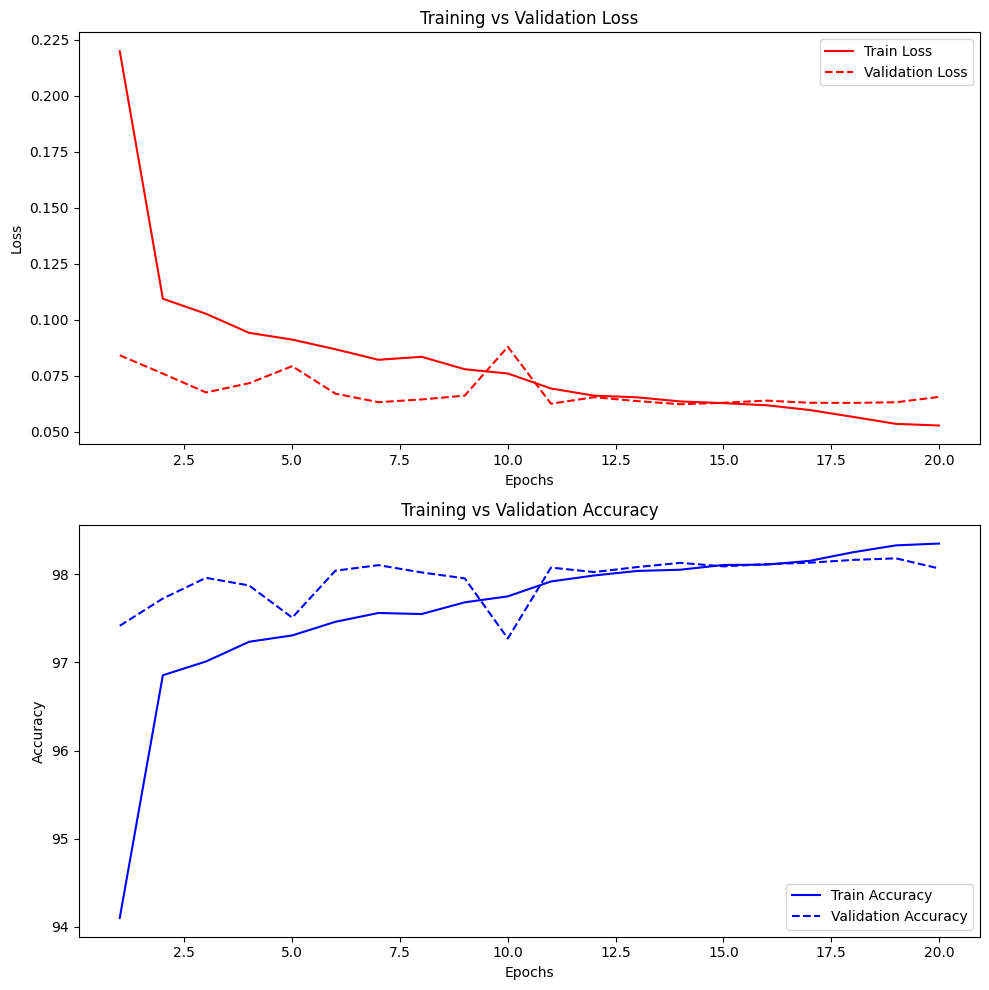

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_records) + 1)
    
train_loss, train_acc = zip(*train_records)
val_loss, val_acc = zip(*val_records)

train_df = pd.DataFrame({'Epoch': epochs, 'Train Loss': train_loss, 'Train Accuracy': train_acc})
val_df = pd.DataFrame({'Epoch': epochs, 'Validation Loss': val_loss, 'Validation Accuracy': val_acc})

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

 # Plot Loss
axes[0].set_title("Training vs Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].plot(epochs, train_loss, 'r-', label="Train Loss")
axes[0].plot(epochs, val_loss, 'r--', label="Validation Loss")
axes[0].legend()

# Plot Accuracy
axes[1].set_title("Training vs Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].plot(epochs, train_acc, 'b-', label="Train Accuracy")
axes[1].plot(epochs, val_acc, 'b--', label="Validation Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()